# Two-Phase Microstructure Generation Using Kanapy

## Goals:

- Quantifying the 2-Phase microstructures through statistical features such as:

	1) Grain size distribution
    
	2) Aspect ratio and tilt angle distributions
    
	3) Phase volume fractions


- Generation of three-dimensional synthetic microstructures based on the selected features using Kanapy


<img src="./Abaqus-RVE.jpg" width="300">

## Example 1: Generating a two-phase microstructure with equiaxed grains

This example demonstrates the workflow for generating two-phase synthetic microstructures with equiaxed grains.

 ### <b> - Import the required dependencies </b>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import json
import numpy as np

### <b> - Determine the Microstructure Parameters </b>

The user can specify the statistical parameters required for the simulation.

In [2]:
Grain_type = 'Equiaxed' 

#Equivalent Diameter:
std = 0.39 
mean = 2.418 
cutoff_min = 8.0 
cutoff_max = 25.0 

#RVE:
sideX = 67.3965
sideY = 67.3965
sideZ = 67.3965
Nx = 51
Ny = 51
Nz = 51

#Simulation:
periodicity = 'True'
output_units = 'mm'

#Phase 1 Volume Fraction: 
VF = 0.5

### <b> - Make the input statistics file in the current directory:</b> `stat_input.json file` 

Input file structure is as follows and it is built in the JSON file format, with the following keywords: 

`Grain type`
`Equivalent diameter`
`RVE`
`Simulation`

In [3]:
stat_input = {
"Grain type": Grain_type,
"Equivalent diameter": 
{
    "std": std,
    "mean": mean,
    "cutoff_min": cutoff_min,
    "cutoff_max": cutoff_max
},
"RVE": 
{
    "sideX": sideX,
    "sideY": sideY,
    "sideZ": sideZ,
    "Nx": Nx,
    "Ny": Ny,
    "Nz": Nz
},
"Simulation": 
{
    "periodicity": periodicity,
    "output_units": output_units
}
}

with open('stat_input.json', 'w') as json_file:
    json.dump(stat_input, json_file, indent=4)

The keyword `Equivalent diameter` takes in four arguments to generate a log-normal distribution for the particle’s equivalent diameter; they are the Normal distribution’s standard deviation and mean, and the minimum and maximum cut-off values for the diameter. The values should correspond to 𝜇𝑚 scale.

The `RVE ` keyword takes two types of input: the side lengths of the final RVE required and the number of voxels per RVE  side length.

The `Simulation` keyword takes in two inputs: A boolean value for periodicity (True/False) and the required unit scale (𝑚𝑚 or 𝜇𝑚) for the output ABAQUS .inp file.

### <b> - Run Kanapy </b>

In [4]:
Runfilename = 'Run.sh'           
                
Run = open(Runfilename,'w')

format = '%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n'

Run.write(format % ('#!/bin/bash',\
                    'eval "$(command conda \'shell.bash\' \'hook\' 2> /dev/null)"',\
                    'conda activate knpy',\
                    'kanapy genStats -f stat_input.json',\
                    'kanapy genRVE -f stat_input.json',\
                    'kanapy pack',\
                    'kanapy voxelize',\
                    'kanapy abaqusOutput',\
                    'kanapy outputStats',\
                    'kanapy plotStats'));

Run.close()

In [5]:
os.system('source Run.sh')

0

`kanapy genStats` command generates particle statistics based on the data provided in the input file and It creates an exemplary ‘Input_distribution.png’ file depicting the Log-normal distribution corresponding to the input statistics defined in `stat_input.json`. 



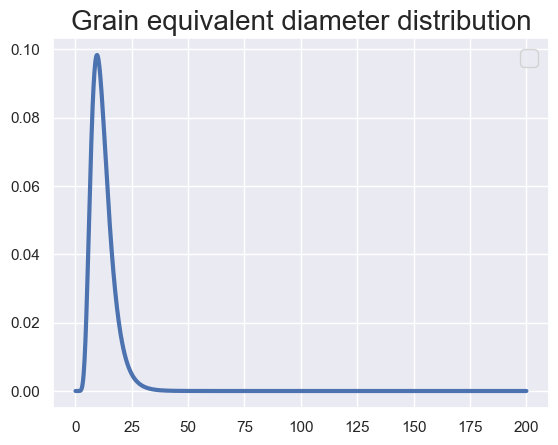

`genRVE` command is executed to generate the necessary particle, RVE, and the simulation attributes, and it writes it to json files. 

`pack` command is called to run the particle packing simulation.

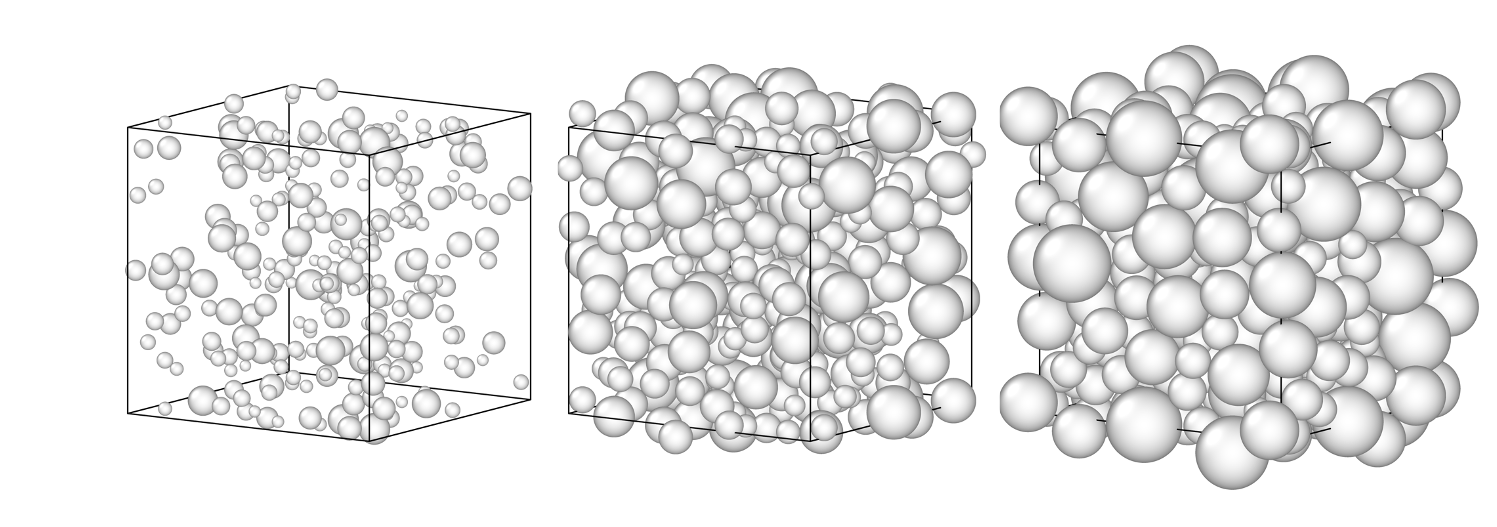

`voxelize` command can be called to generate the hexahedral mesh. It populates the simulation box with voxels and assigns the voxels to the respective particles (Spheres). 

The `abaqusOutput` command can be called to write out the Abaqus (.inp) input file. The Abaqus (.inp) file will be written out in either 𝑚𝑚 or 𝜇𝑚 scale, depending on the user requirement specified in the input file.

For comparing the input and the output equivalent diameter statistics the `outputStats` command can be called. This command writes the diameter values in either 𝑚𝑚 or 𝜇𝑚 scale, depending on the user requirement specified in the input file.

The `outputStats` command also writes out the L1-error between the input and output diameter distributions.

The `plotStats` command outputs a figure comparing the input and output diameter distributions.

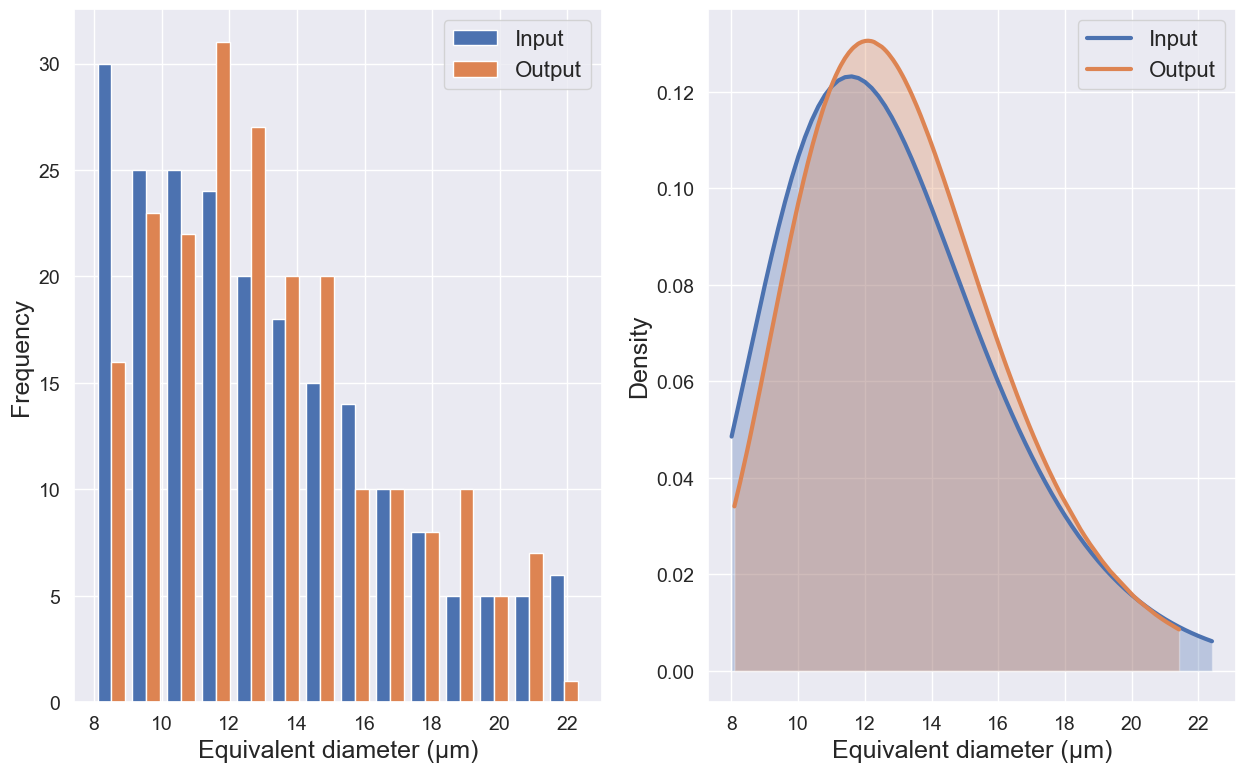

### <b> - Assign a material to each grain

In [7]:
with open('./json_files/nodeDict.json') as json_file:
    nodeDict = json.load(json_file)

with open('./json_files/elmtDict.json') as json_file:
    elmtDict = json.load(json_file)

with open('./json_files/elmtSetDict.json') as json_file:
    elmtSetDict = json.load(json_file)
               
        
nodes = np.array(list(nodeDict.values()))
elmts = np.array(list(elmtDict.values()))
elmtSetKeys = np.array(list(elmtSetDict.keys()))
elmtSets = np.array(list(elmtSetDict.values()))
nGrains = elmtSets.shape[0]
nelmt = Nx * Ny * Nz
nnode = nelmt + Nx * Ny + Ny * Nz + Nx * Nz + Nx + Ny + Nz + 1
Voxel_resolutionX = sideX/Nx
Voxel_resolutionY = sideY/Ny
Voxel_resolutionZ = sideZ/Nz
Voxelvolume = Voxel_resolutionX * Voxel_resolutionY * Voxel_resolutionZ
Volume =  nelmt*Voxelvolume
nElmtspergrain = np.zeros(nGrains, dtype = int)
    
for i in range(0,nGrains):
    nElmtspergrain[i] = len(elmtSets[i])
GrainV = nElmtspergrain * Voxelvolume
    
grainPhase = np.zeros((1,nGrains))
VF1 = 0
nphase1 = 0
ii = 0
while (VF1 < VF):
    if abs(VF-VF1) < 0.01:
        break
    rand = np.random.randint(0,nGrains-1)
    ii = ii + 1
    if grainPhase[0,rand] == 0:
        grainPhase[0,rand] = 1
        VF1 = VF1 + GrainV[rand]/Volume
        nphase1 = nphase1 + 1;
        if VF1 - VF > 0.01:
            grainPhase[0,rand] = 0;
            VF1 = VF1 - GrainV[rand]/Volume;
            nphase1 = nphase1 - 1;
                
    
Data = np.zeros((Nx,Ny,Nz))
xyz = np.zeros((3,8))
iii = 0
jjj = 0
kkk = 0
SUM = 0
for gg in range(0,nGrains):
    for ee in range(0,nElmtspergrain[gg]):
        Element = elmtSets[gg][ee]
        ElementNodes = elmts[Element-1,0:8]
        for nn in range(0,8):
            NNN = ElementNodes[nn]
            xyz[:,nn] = nodes[NNN-1,:]
         
        iii = int(min(xyz[0,:])/Voxel_resolutionX)
        jjj = int(min(xyz[1,:])/Voxel_resolutionY)
        kkk = int(min(xyz[2,:])/Voxel_resolutionZ)
        Data[iii,jjj,kkk] = grainPhase[0,gg]  
        SUM = SUM + Data[iii,jjj,kkk]
        
Datafilename = 'two_phase_microstructure_data.txt'
f = open(Datafilename,'w')

for iii in range(0,Nx):
    for jjj in range(0,Ny):
        for kkk in range(0,Nz):
            f.write('%d\t%d\t%d\t%d\n' % (iii,jjj,kkk,Data[iii,jjj,kkk]))

### <b> - Write the Abaqus Input File

In [9]:
Abaqusfilename = 'Abaqus_2Phase_Equiaxed.inp'           

Abaqus = open(Abaqusfilename,'w')

Abaqus.write('%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n' % ('** Input file generated by Python',\
'** Nodal coordinates scale in mm',\
'*HEADING',\
'*PREPRINT,ECHO=NO,HISTORY=NO,MODEL=NO,CONTACT=NO',\
'**',\
'** PARTS',\
'**',\
'*Part, name=PART-1',\
'*Node'))

for ab in range(0,nnode):
    Abaqus.write('%d%s%g%s%g%s%g\n' % (ab+1,', ',nodes[ab,0]*0.001,', ',nodes[ab,1]*0.001,', ',nodes[ab,2]*0.001))    

Abaqus.write('%s\n' % '*ELEMENT, TYPE=C3D8')

for ab in range(0,nelmt):
    Abaqus.write('%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d\n'\
    % (ab+1,', ',elmts[ab,0],', ',elmts[ab,1],', ',\
    elmts[ab,2],', ',elmts[ab,3],', ',elmts[ab,4],', ',\
    elmts[ab,5],', ',elmts[ab,6],', ',elmts[ab,7]))

for ab in range(0,nGrains):
    Abaqus.write('%s%d%s\n' % ('*ELSET, ELSET=Grain', ab+1, '_set'))
    n16 = int(np.floor(nElmtspergrain[ab]/16))
    for abbb in range(0,n16):
        Abaqus.write('%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d\n' %\
        (elmtSets[ab][abbb*16],', ',elmtSets[ab][abbb*16+1],', ',elmtSets[ab][abbb*16+2],', ',elmtSets[ab][abbb*16+3],', ',\
        elmtSets[ab][abbb*16+4],', ',elmtSets[ab][abbb*16+5],', ',elmtSets[ab][abbb*16+6],', ',elmtSets[ab][abbb*16+7],', ',\
        elmtSets[ab][abbb*16+8],', ',elmtSets[ab][abbb*16+9],', ',elmtSets[ab][abbb*16+10],', ',elmtSets[ab][abbb*16+11],', ',\
        elmtSets[ab][abbb*16+12],', ',elmtSets[ab][abbb*16+13],', ',elmtSets[ab][abbb*16+14],', ',elmtSets[ab][abbb*16+15]))
    for abbb in range((n16)*16,int(nElmtspergrain[ab])-1):
        Abaqus.write('%d%s' % (elmtSets[ab][abbb],', '))
    Abaqus.write('%d\n' % elmtSets[ab][-1])


for ab in range(0,nGrains):
    Abaqus.write('%s%d%s%d\n' % ('*Solid Section, elset=Grain',ab,'_set, material=Phase_',grainPhase[0,ab]))

Abaqus.write('*End Part\n')
Abaqus.write('**\n')
Abaqus.write('**\n')
Abaqus.write('** ASSEMBLY\n')
Abaqus.write('**\n')
Abaqus.write('*Assembly, name=Assembly\n')
Abaqus.write('**\n')
Abaqus.write('*Instance, name=PART-1-1, part=PART-1\n')
Abaqus.write('*End Instance\n')
Abaqus.write('*End Assembly\n')
Abaqus.write('**\n')
Abaqus.write('**MATERIALS\n')
Abaqus.write('*MATERIAL, NAME="PHASE_0"\n')
Abaqus.write('*MATERIAL, NAME="PHASE_1"\n')
Abaqus.write('**\n')  

Abaqus.close() 

## Example 2: Generating a two-phase microstructure with elongated grains:

This example demonstrates the workflow for generating 2-phase synthetic microstructures with elongated grains. 

In [10]:
Grain_type = 'Elongated' 

#Equivalent Diameter:
std = 0.39 
mean = 2.418 
cutoff_min = 8.0 
cutoff_max = 25.0 

#Aspect Ratio:
std_AR = 0.3
mean_AR = 0.918
cutoff_min_AR = 1.0
cutoff_max_AR = 4.0

#Tilt Angle:
std_TA = 15.8774
mean_TA = 87.4178
cutoff_min_TA = 75.0
cutoff_max_TA = 105.0

#RVE:
sideX = 86
sideY = 86
sideZ = 86
Nx = 65
Ny = 65
Nz = 65

#Simulation:
periodicity = 'True'
output_units = 'mm'

#Phase 1 Volume Fraction:
VF = 0.5

In [11]:
stat_input = {
"Grain type": Grain_type,
"Equivalent diameter": 
{
    "std": std,
    "mean": mean,
    "cutoff_min": cutoff_min,
    "cutoff_max": cutoff_max
},
"Aspect ratio": 
{
    "std": std_AR,
    "mean": mean_AR,
    "cutoff_min": cutoff_min_AR,
    "cutoff_max": cutoff_max_AR
},
"Tilt angle": 
{
    "std": std_TA,
    "mean": mean_TA,
    "cutoff_min": cutoff_min_TA,
    "cutoff_max": cutoff_max_TA
},
"RVE": 
{
    "sideX": sideX,
    "sideY": sideY,
    "sideZ": sideZ,
    "Nx": Nx,
    "Ny": Ny,
    "Nz": Nz
},
"Simulation": 
{
    "periodicity": periodicity,
    "output_units": output_units
}
}

with open('stat_input.json', 'w') as json_file:
    json.dump(stat_input, json_file, indent=4)

The `Aspect ratio` and `Tilt angle` takes the mean and the standard deviation value as input.

The workflow is similar to the one described earlier. The `outputStats` command not only writes out the equivalent diameters, but also the major and minor diameters of the ellipsoidal particles and grains.

In [17]:
Runfilename = 'Run.sh'           
                
Run = open(Runfilename,'w')

format = '%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n'

Run.write(format % ('#!/bin/bash',\
                    'eval "$(command conda \'shell.bash\' \'hook\' 2> /dev/null)"',\
                    'conda activate knpy',\
                    'kanapy genStats -f stat_input.json',\
                    'kanapy genRVE -f stat_input.json',\
                    'kanapy pack',\
                    'kanapy voxelize',\
                    'kanapy abaqusOutput',\
                    'kanapy outputStats',\
                    'kanapy plotStats'));
Run.close()

In [18]:
os.system('source Run.sh');

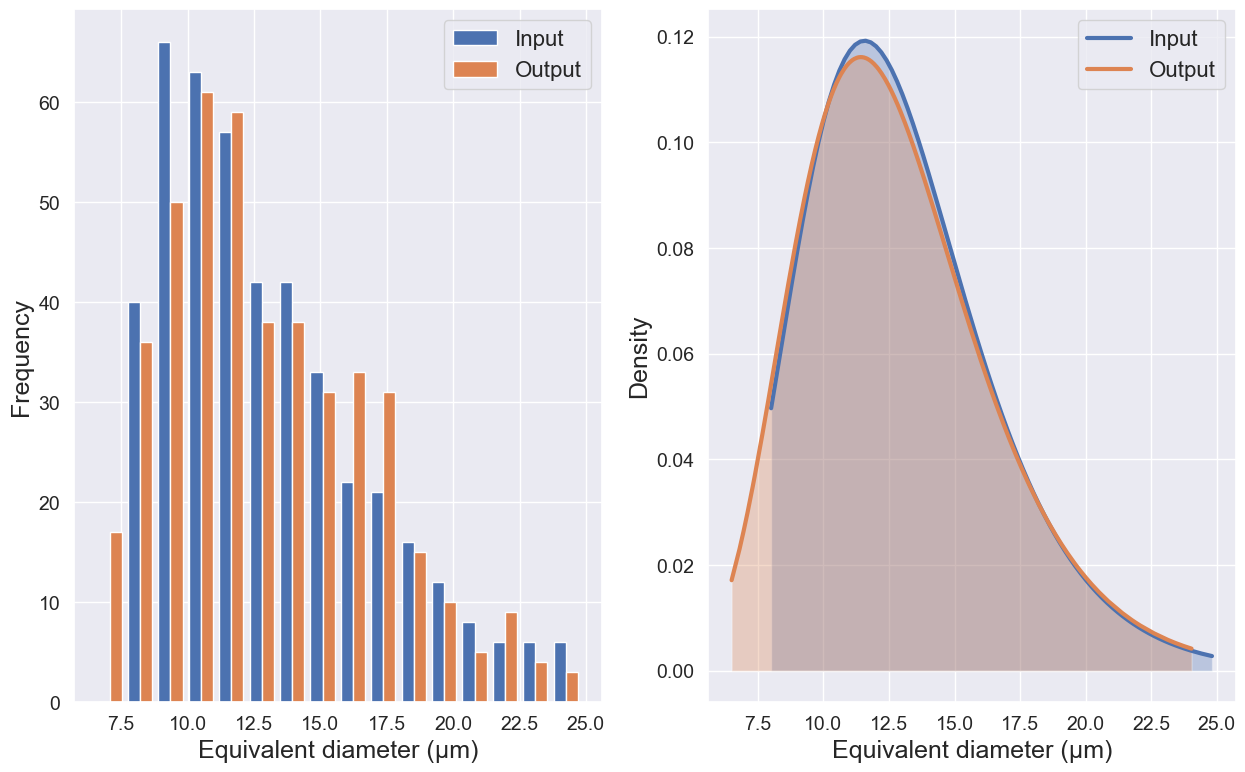

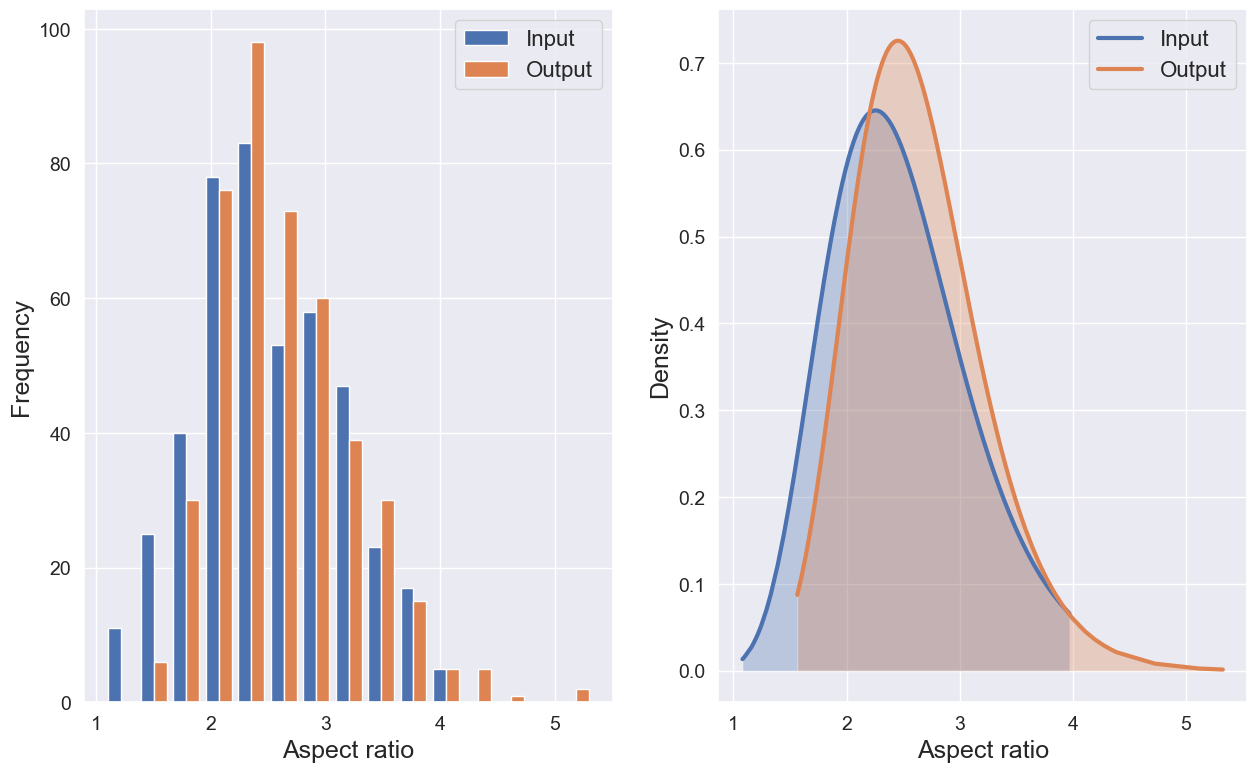

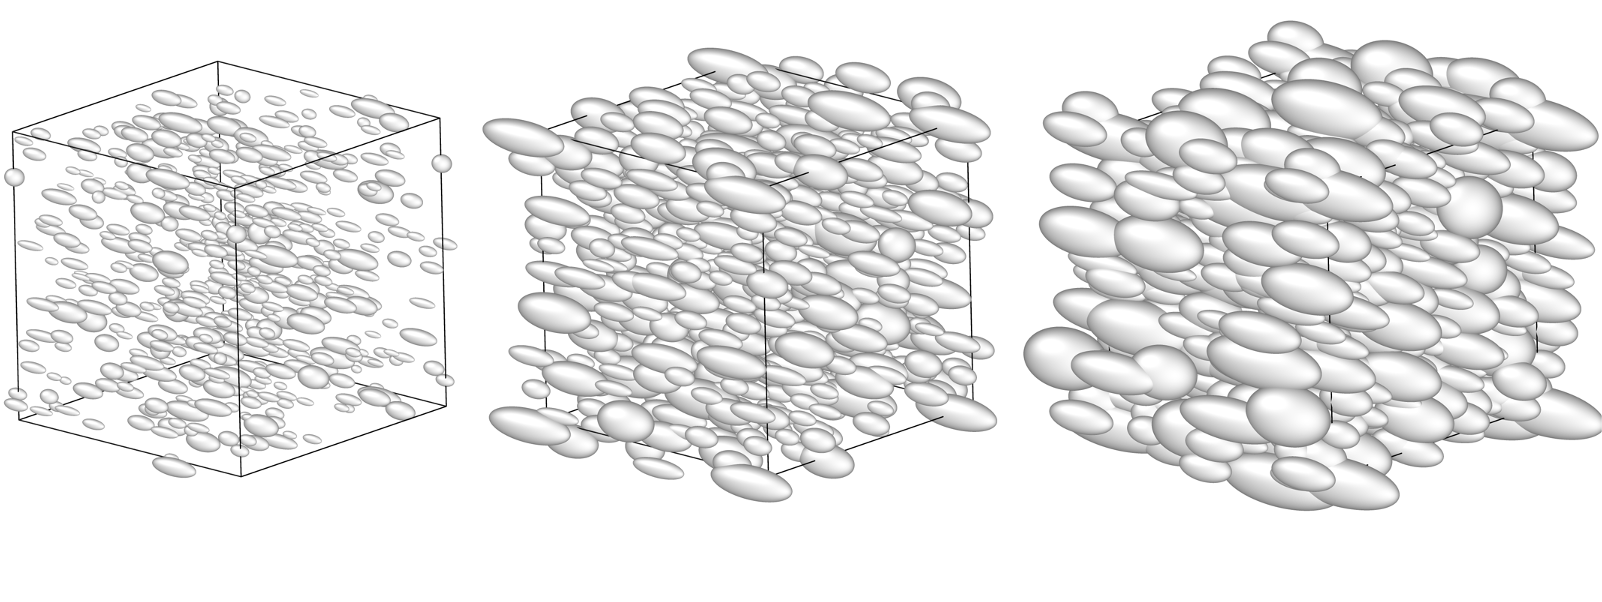

In [19]:
with open('./json_files/nodeDict.json') as json_file:
    nodeDict = json.load(json_file)

with open('./json_files/elmtDict.json') as json_file:
    elmtDict = json.load(json_file)

with open('./json_files/elmtSetDict.json') as json_file:
    elmtSetDict = json.load(json_file)
               
        
nodes = np.array(list(nodeDict.values()))
elmts = np.array(list(elmtDict.values()))
elmtSetKeys = np.array(list(elmtSetDict.keys()))
elmtSets = np.array(list(elmtSetDict.values()))
nGrains = elmtSets.shape[0]
nelmt = Nx * Ny * Nz
nnode = nelmt + Nx * Ny + Ny * Nz + Nx * Nz + Nx + Ny + Nz + 1
Voxel_resolutionX = sideX/Nx
Voxel_resolutionY = sideY/Ny
Voxel_resolutionZ = sideZ/Nz
Voxelvolume = Voxel_resolutionX * Voxel_resolutionY * Voxel_resolutionZ
Volume =  nelmt*Voxelvolume
nElmtspergrain = np.zeros(nGrains, dtype = int)
    
for i in range(0,nGrains):
    nElmtspergrain[i] = len(elmtSets[i])
GrainV = nElmtspergrain * Voxelvolume
    
grainPhase = np.zeros((1,nGrains))
VF1 = 0
nphase1 = 0
ii = 0
while (VF1 < VF):
    if abs(VF-VF1) < 0.01:
        break
    rand = np.random.randint(0,nGrains-1)
    ii = ii + 1
    if grainPhase[0,rand] == 0:
        grainPhase[0,rand] = 1
        VF1 = VF1 + GrainV[rand]/Volume
        nphase1 = nphase1 + 1;
        if VF1 - VF > 0.01:
            grainPhase[0,rand] = 0;
            VF1 = VF1 - GrainV[rand]/Volume;
            nphase1 = nphase1 - 1;
                
    
Data = np.zeros((Nx,Ny,Nz))
xyz = np.zeros((3,8))
iii = 0
jjj = 0
kkk = 0
SUM = 0
for gg in range(0,nGrains):
    for ee in range(0,nElmtspergrain[gg]):
        Element = elmtSets[gg][ee]
        ElementNodes = elmts[Element-1,0:8]
        for nn in range(0,8):
            NNN = ElementNodes[nn]
            xyz[:,nn] = nodes[NNN-1,:]
         
        iii = int(min(xyz[0,:])/Voxel_resolutionX)
        jjj = int(min(xyz[1,:])/Voxel_resolutionY)
        kkk = int(min(xyz[2,:])/Voxel_resolutionZ)
        Data[iii,jjj,kkk] = grainPhase[0,gg]  
        SUM = SUM + Data[iii,jjj,kkk]
        
Datafilename = 'two_phase_microstructure_data.txt'
f = open(Datafilename,'w')

for iii in range(0,Nx):
    for jjj in range(0,Ny):
        for kkk in range(0,Nz):
            f.write('%d\t%d\t%d\t%d\n' % (iii,jjj,kkk,Data[iii,jjj,kkk]))

In [20]:
Abaqusfilename = 'Abaqus_2Phase_Elongated.inp'           

Abaqus = open(Abaqusfilename,'w')

Abaqus.write('%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n' % ('** Input file generated by Python',\
'** Nodal coordinates scale in mm',\
'*HEADING',\
'*PREPRINT,ECHO=NO,HISTORY=NO,MODEL=NO,CONTACT=NO',\
'**',\
'** PARTS',\
'**',\
'*Part, name=PART-1',\
'*Node'))

for ab in range(0,nnode):
    Abaqus.write('%d%s%g%s%g%s%g\n' % (ab+1,', ',nodes[ab,0]*0.001,', ',nodes[ab,1]*0.001,', ',nodes[ab,2]*0.001))    

Abaqus.write('%s\n' % '*ELEMENT, TYPE=C3D8')

for ab in range(0,nelmt):
    Abaqus.write('%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d\n'\
    % (ab+1,', ',elmts[ab,0],', ',elmts[ab,1],', ',\
    elmts[ab,2],', ',elmts[ab,3],', ',elmts[ab,4],', ',\
    elmts[ab,5],', ',elmts[ab,6],', ',elmts[ab,7]))

for ab in range(0,nGrains):
    Abaqus.write('%s%d%s\n' % ('*ELSET, ELSET=Grain', ab+1, '_set'))
    n16 = int(np.floor(nElmtspergrain[ab]/16))
    for abbb in range(n16):
        Abaqus.write('%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d%s%d\n' %\
        (elmtSets[ab][abbb*16],', ',elmtSets[ab][abbb*16+1],', ',elmtSets[ab][abbb*16+2],', ',elmtSets[ab][abbb*16+3],', ',\
        elmtSets[ab][abbb*16+4],', ',elmtSets[ab][abbb*16+5],', ',elmtSets[ab][abbb*16+6],', ',elmtSets[ab][abbb*16+7],', ',\
        elmtSets[ab][abbb*16+8],', ',elmtSets[ab][abbb*16+9],', ',elmtSets[ab][abbb*16+10],', ',elmtSets[ab][abbb*16+11],', ',\
        elmtSets[ab][abbb*16+12],', ',elmtSets[ab][abbb*16+13],', ',elmtSets[ab][abbb*16+14],', ',elmtSets[ab][abbb*16+15]))
    for abbb in range((n16)*16,int(nElmtspergrain[ab])-1):
        Abaqus.write('%d%s' % (elmtSets[ab][abbb],', '))
    Abaqus.write('%d\n' % elmtSets[ab][-1])


for ab in range(nGrains):
    Abaqus.write('%s%d%s%d\n' % ('*Solid Section, elset=Grain',ab,'_set, material=Phase_',grainPhase[0,ab]))

Abaqus.write('*End Part\n')
Abaqus.write('**\n')
Abaqus.write('**\n')
Abaqus.write('** ASSEMBLY\n')
Abaqus.write('**\n')
Abaqus.write('*Assembly, name=Assembly\n')
Abaqus.write('**\n')
Abaqus.write('*Instance, name=PART-1-1, part=PART-1\n')
Abaqus.write('*End Instance\n')
Abaqus.write('*End Assembly\n')
Abaqus.write('**\n')
Abaqus.write('**MATERIALS\n')
Abaqus.write('*MATERIAL, NAME="PHASE_0"\n')
Abaqus.write('*MATERIAL, NAME="PHASE_1"\n')
Abaqus.write('**\n')  

Abaqus.close()